# Previsión de la inflación mexicana mediante redes neuronales

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Load the data
# Descargadi de https://www.banxico.org.mx/SieInternet/consultarDirectorioInternetAction.do?accion=consultarCuadro&idCuadro=CP151&locale=en

path = 'data/Consulta_03.csv'
df = pd.read_csv(path, sep=',', encoding='utf-8')
columnas = df.columns  
df

,Fecha,Inflacion Indice de precios al consumidor (INPC) mensual,Inflacion Indice de precios al consumidor (INPC) acumulada en el anio,Inflacion Indice de precios al consumidor (INPC) anual,Inflacion subyacente mensual,Inflacion subyacente acumulada en el año,Inflacion subyacente anual,Inflacion no subyacente mensual,Inflacion no subyacente acumulada en el año,Inflacion no subyacente anual
0,01/01/1971,16.470588,-78.891258,5.117271,N/E,N/E,N/E,N/E,N/E,N/E
1,01/02/1971,-51.764706,-70.149254,14.712154,N/E,N/E,N/E,N/E,N/E,N/E
2,01/03/1971,-55.294118,-61.833689,16.631130,N/E,N/E,N/E,N/E,N/E,N/E
3,01/04/1971,-40.000000,-50.746269,25.159915,N/E,N/E,N/E,N/E,N/E,N/E
4,01/05/1971,-75.294118,-46.055437,25.159915,N/E,N/E,N/E,N/E,N/E,N/E
...,...,...,...,...,...,...,...,...,...,...
635,01/12/2023,86.842105,-40.409207,-40.409207,-32.31,-39.04,-39.04,-482.50,-45.93,-45.93
636,01/01/2024,25.352113,-80.901288,4.721030,-9.09,-92.14,-6.48,54.90,-30.09,54.57
637,01/02/2024,-87.323944,-78.755365,-5.579399,11.36,-82.32,-8.84,-171.90,-63.13,8.26
638,01/03/2024,-59.154930,-72.532189,-5.150215,0.00,-73.67,-10.61,-110.46,-67.85,18.88


Text(0.5, 1.0, 'Inflacion Indice de precios al consumidor (INPC) mensual de 01/01/1971 a 01/08/1971')

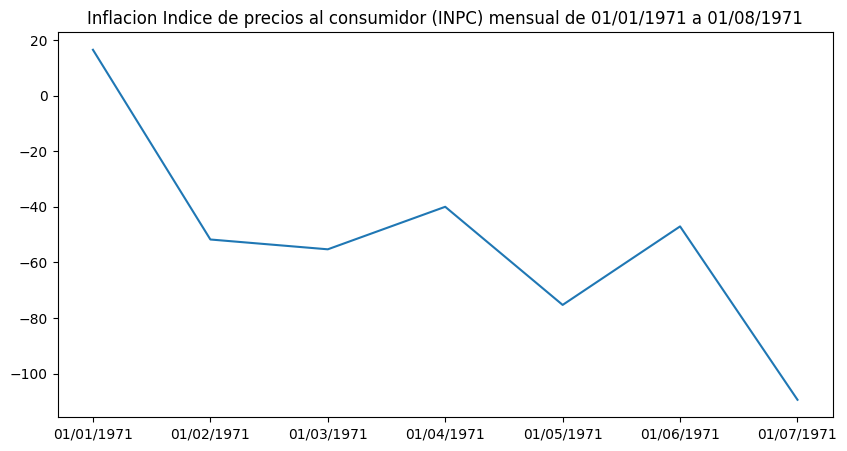

In [9]:
# Print Inflacion indice de precios al consumidor
num = 7
plt.figure(figsize=(10,5))
fecha_inicial = df['Fecha'][0]
fecha_final = df['Fecha'][num]

fecha = df['Fecha'][0:num]
inflacion = df[columnas[1]][0:num]
plt.plot(fecha, inflacion,)
plt.title(str(columnas[1])+" de "+str(fecha_inicial)+" a "+str(fecha_final))



In order to train the NN we used a database provided by the Bank
of Mexico which contains monthly inflation, annual inflation
and annual inflation expected according to inflation measured
each month. January inflation is used as the input vector and
annual inflation as the target vector. Expected inflation is used
to compare NN results with the Bank of Mexico expectations

In [ ]:
# Definimos la inflacion en enero como el vector de entrada
inflacion_enero = df[columnas[1]][0:5]


NameError: name 'df' is not defined

So database will contain annual inflation values from 1970 to 1993
and the selected NN model will be used to forecast inflation
from 1994 to 2010. From the database, 70% of data will be
used to train the NN and the remain 30% will be used to
measure its performance according to the mean square error
(MSE). The NN model with the least MSE will be selected to
forecast inflation. The activation function used in the hidden
layers was the hyperbolic tangent and the rest of the
specifications were set to default Matlab values.